# Annual cycles
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [7]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load observations

### Topography

In [8]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

### Temperature

In [10]:
obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar=obs.time.encoding['calendar'])

In [11]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_tas = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_70x120_35x60.nc


### Snow Cover

In [17]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [18]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Precipitation

#### APHRODITE

In [19]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [20]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_aphro = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### GPCP

In [21]:
obs_longname = 'GPCP CDR v2.3 (2.5°)'
obs_name = 'GPCP'

obs = xr.open_mfdataset(
    # '/bdd/GPCP/netcdf/surf-rr_gpcp_multi-sat_250d_01mth_*_v2.2-02.nc', combine='by_coords'
    # -> missing some month (ex 2014/11)
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

In [22]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_gpcp = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_14x24_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load results

In [27]:
list_vars = ['tas', 'snc', 'pr']
temp = [None]*len(list_vars)

for i, var in enumerate(list_vars):
    temp[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_ac.nc'
    )
    
multimodel_ensemble_ac = xr.concat(temp, pd.Index(list_vars, name='var'))

## Plot

In [31]:
len(zones)

4

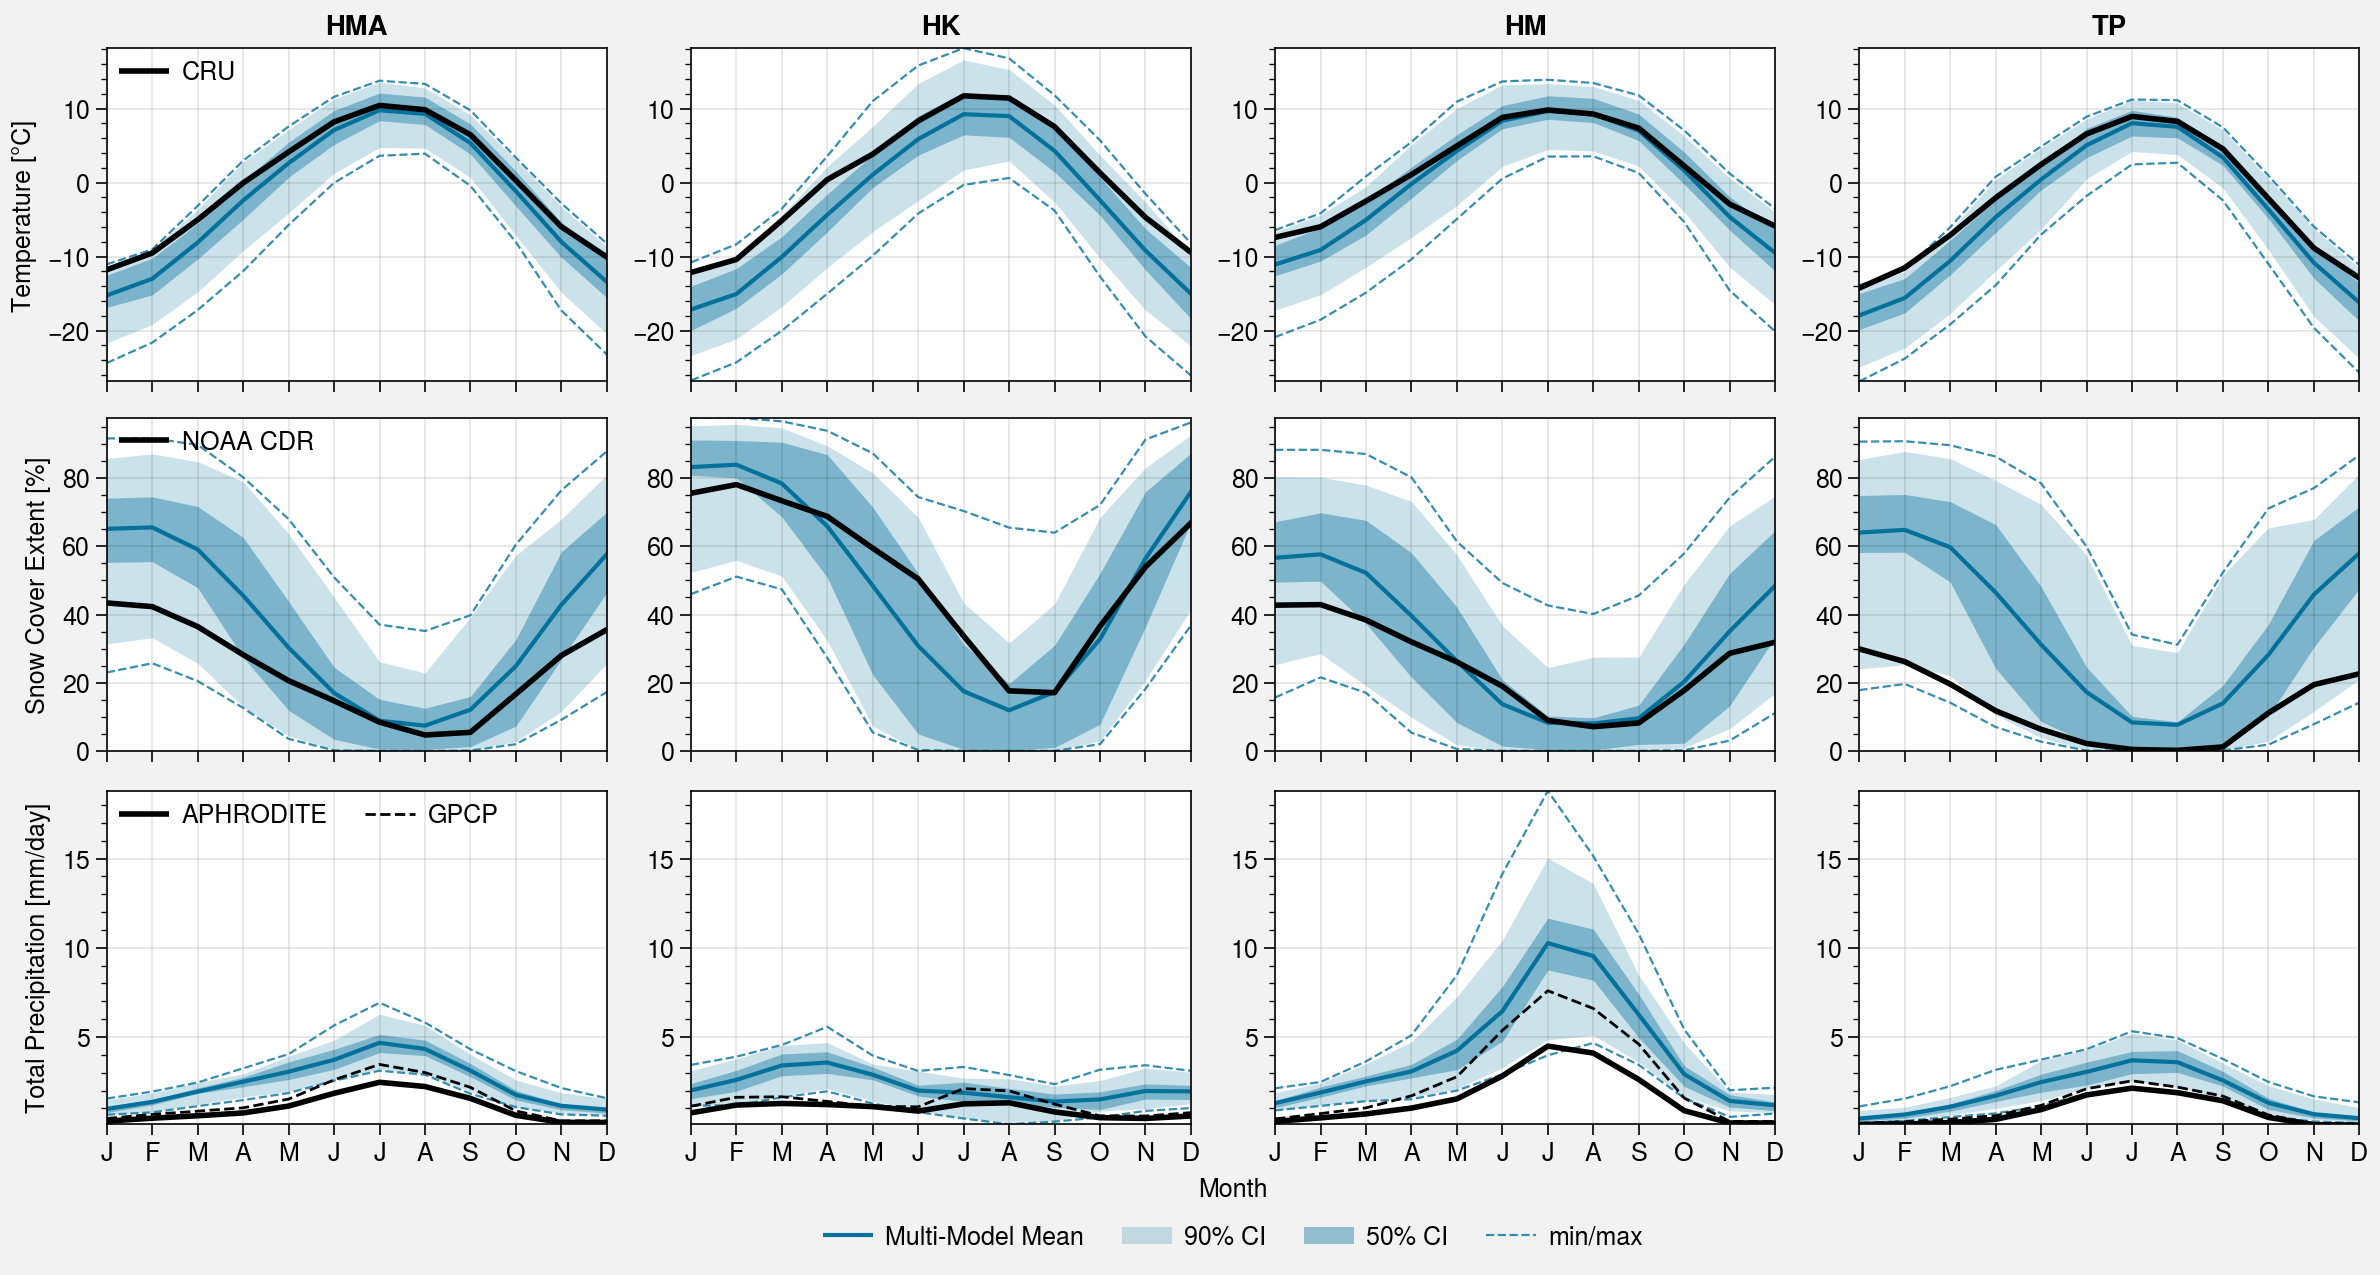

In [51]:
f, axs = plot.subplots(ncols=4, nrows=3, aspect=1.5, sharey=0)

color_model = 'ocean blue'
color_obs = 'black'

n_ax = 0
for i_var, var in enumerate(list_vars):
    for i in range(len(zones)):
        means = multimodel_ensemble_ac.sel(var=var)[i].mean('model')

        # Compute quantiles  
        shadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.25, 0.75], dim='model')  # dark shading
        fadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.05, 0.95], dim='model')  # light shading

        h1 = axs[n_ax].plot(
            means, 
            shadedata=shadedata, fadedata=fadedata,
            shadelabel='50% CI', fadelabel='90% CI',
            label='Multi-Model Mean', color=color_model, 
        )

        # Add min/max
        h2 = axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].min('model'),
            label='min/max', linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )
        axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].max('model'),
            linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )

        # Plot observations
        if var == 'tas':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_tas[i], label='CRU', color=color_obs, linewidth=2)
        elif var == 'snc':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_snc[i], label='NOAA CDR', color=color_obs, linewidth=2)
        elif var == 'pr':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_pr_aphro[i], label='APHRODITE', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_pr_gpcp[i], label='GPCP', color=color_obs, linewidth=1, linestyle='--')

        axs[n_ax].format( 
            ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
            xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
            xlabel='Month'
        )
        
        # Add obs legend and ylabel
        if i == 0:
            if var in ['pr']:
                h = [h3, h4]
            else:
                h = [h3]
            axs[n_ax].legend(h, loc='ul', frame=False)
            
            labels=['Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']
            axs[n_ax].format( 
                ylabel = labels[i_var]
            )
        
        n_ax += 1

f.legend([h1[0], h1[1], h1[2], h2], loc='b', frame=False, ncols=4, order='F', center=False)

axs.format(
#     suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology',
    collabels=zones
)
    
filename = 'ac_all_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')